In [8]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset,Dataset
import time
import numpy as np
import matplotlib.pyplot as plt
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class Net(nn.Module):
    def __init__(self , model):	#此处的model参数是已经加载了预训练参数的模型，方便继承预训练成果
        super(Net, self).__init__()
        #取掉model的后两层
        self.resnet_layer = nn.Sequential(*list(model.children())[:-2])
        self.dr_layer1=nn.modules.conv.Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.dr_bn1=nn.modules.batchnorm.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dr_layer2=nn.modules.conv.Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.dr_bn2=nn.modules.batchnorm.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dr_layer3=nn.modules.conv.Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.dr_bn3=nn.modules.batchnorm.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dr_layer4=nn.modules.conv.Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

        
    def forward(self, x):
        x = self.resnet_layer(x)
        x=self.dr_layer1(x)
        x=self.dr_bn1(x)
        x=self.dr_layer2(x)
        x=self.dr_bn2(x)
        x=self.dr_layer3(x)
        x=self.dr_bn3(x)
        x=self.dr_layer4(x)
        return x

In [11]:
resnet50 = models.resnet50(pretrained=True)
resnet50.conv1=nn.modules.conv.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model = Net(resnet50) 
model=model.to(device)
# print(model)

In [14]:
data=np.load('/home/chase/Boyka/Lyu/data/rainfall/reg/data_reg_2000.npy')
data=np.expand_dims(data,axis=1)
# data=torch.from_numpy(data)
data=torch.FloatTensor(data)
# print(type(data[0][0][0]))
# print(data[0][0][0])
label=np.load('/home/chase/Boyka/Lyu/data/rainfall/reg/label_reg_2000.npy')
print(label.shape)
label=np.expand_dims(label,axis=1)
# label=torch.from_numpy(label)
label=torch.FloatTensor(label)
# print(label[0][0][0])
# print(data.shape,label.shape)
train_x=data[:-400]
test_x=data[-400:]
train_y=label[:-400]
test_y=label[-400:]
print(data.shape,label.shape)

(2000, 8, 8)
torch.Size([2000, 1, 256, 256]) torch.Size([2000, 1, 8, 8])


In [15]:
train_dataset = TensorDataset(train_x,train_y)
test_dataset = TensorDataset(test_x,test_y)
train_loader=DataLoader(dataset=train_dataset,batch_size=32,shuffle=True,num_workers=2)
test_loader=DataLoader(dataset=test_dataset,batch_size=32,shuffle=True,num_workers=2)
train_data_size=len(train_loader)
valid_data_size=len(test_loader)

In [21]:
model=torch.load('2000_500_models/rivers_model_500.pt')

In [22]:
model.to(device)

Net(
  (resnet_layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64,

In [33]:
label=[]
pre=[]
with torch.no_grad():
    model.eval()
    for j, (inputs, labels) in enumerate(test_loader):
        label.extend(labels.numpy().tolist())
#         label+=labels.numpy()
        inputs = inputs.to(device)
#         labels = labels.to(device)
        outputs = model(inputs)
        pre.extend(outputs.to("cpu").numpy().tolist())
#         pre+=outputs.to("cpu").numpy()



In [39]:
pre=np.squeeze(pre)
label=np.squeeze(label)
np.array(pre).shape

(400, 8, 8)

In [40]:
np.save('label_400.npy',label)
np.save('pre_400.npy',pre)

No handles with labels found to put in legend.


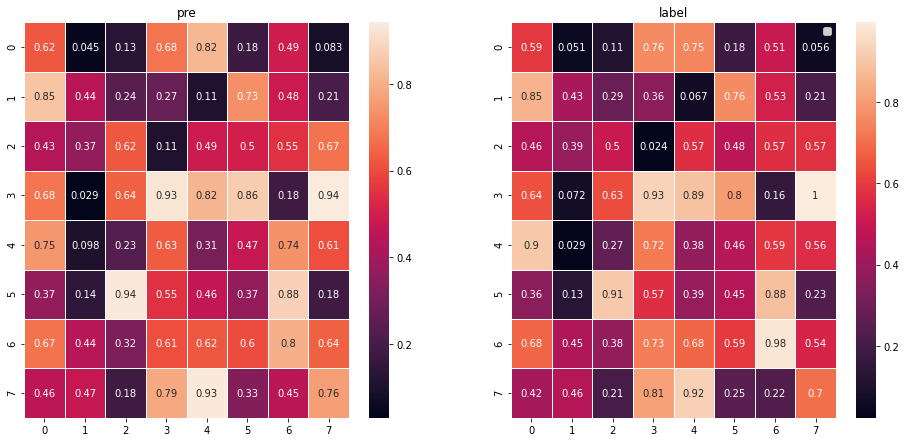

In [42]:
import seaborn as sns
plt.figure(figsize=(16,16))
ax1 =plt.subplot(221)
ax1.set_title('pre')
h=sns.heatmap(pre[0], annot=True,linewidths=0.5)  

ax2=plt.subplot(222)
ax2.set_title('label')
h=sns.heatmap(label[0], annot=True,linewidths=0.5)  

plt.legend()
plt.show()

In [44]:
data_max=np.max(label) if np.max(label)>np.max(pre) else np.max(pre)
data_min=np.min(label) if np.min(label)<np.min(pre) else np.min(pre)
print(data_max,data_min)

1.0147613286972046 -0.011173279955983162


No handles with labels found to put in legend.


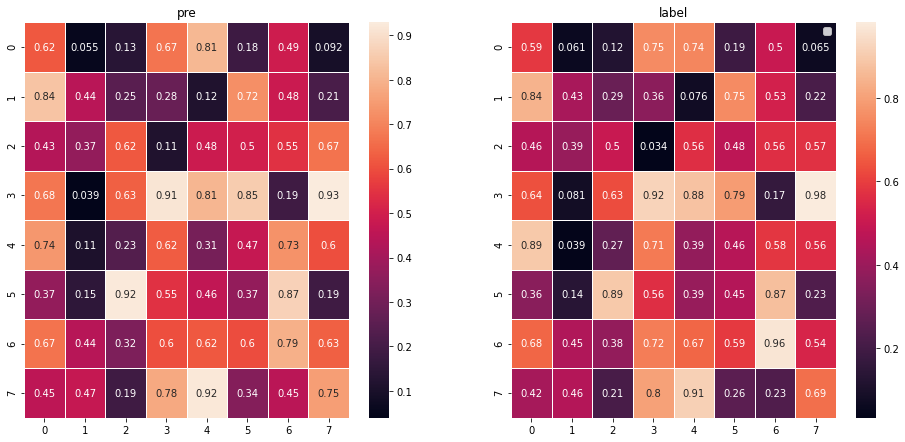

In [46]:
import seaborn as sns
plt.figure(figsize=(16,16))
ax1 =plt.subplot(221)
ax1.set_title('pre')
h=sns.heatmap((pre[0]-data_min)/(data_max-data_min), annot=True,linewidths=0.5)  

ax2=plt.subplot(222)
ax2.set_title('label')
h=sns.heatmap((label[0]-data_min)/(data_max-data_min), annot=True,linewidths=0.5)  

plt.legend()
plt.show()